# Representation of sonic data

Musical information can be stored in a variety of ways and also evolved through history.
One big transition was for example the capability to store the waveform of a place and time through a physical object, which then again can be re-processed and transformed back into a pressure wave of air through loudspeakers.

Another common method is the notation of notes through a score, and while this inscription covers a large domain of western music history it also lacks fundamental aspects of precise information, opening the room for interpretation.

The idea of transcribing the action of practicing a piano into a score reveals that such a score struggles representing common topics in practicing such as

* flucuation in tempo
* small deviations in timing
* precise articulation of a note

The score fails to represent this data because it favors a more idealistic proposition of a performance than to represent an actual, definitive version.

The deviation between score and performance is the very essence of an interpretation of a piece.
Training the piano covers therefore not only the physical capability of hitting keys at the right time but also their pronunciation which is hinted by the score but relies on a more direct connection to the music in order to transport the musical intention and idea of a musical idea.

A common way to represent the performance on a keyboard is through [MIDI](https://en.wikipedia.org/wiki/MIDI), which allows to store the the pressing and releasing of each key at specific time points with a given pressure which is represented via $2^{7} = 128$ steps.

While within a digital domain the representation is faithful, attaching it to physical objects may introduce *smearing* as the transition between the physical action to a digital quantized information may introduce a delta.

While the representation of MIDI is also limited, it also provides a sweet spot of a reasonable approximation of a given performance and has the advantage of being a standard which allows interaction with many different kind of instruments and software.

## Parsing MIDI files

Python has a variety of MIDI libraries and this course decides to go with [`pretty_midi`](https://github.com/craffel/pretty-midi) which provides some nice convenience methods.

In order to obtain a basic understanding of MIDI data it is a good practice to parse a simple MIDI file, for example [31 Good Night To You All.mid](https://commons.wikimedia.org/wiki/File:31_Good_Night_To_You_All.mid) from Wikimedia.

In [ ]:
midi_file_path = "../data/31_Good_Night_To_You_All.mid"

with open(midi_file_path, "rb") as f:
    midi_data = f.read()

print(midi_data[0:100])

b"MThd\x00\x00\x00\x06\x00\x01\x00\x04\x03\xc0MTrk\x00\x00\x00)\x00\xffX\x04\x03\x02\x18\x08\x00\xffY\x02\xff\x00\x00\xffQ\x03\t'\xc0\x00\xff\x02\x0cCopyright \xa9 \x01\xff/\x00MTrk\x00\x00\x02.\x8f\x00\xc0\x00\x00\xb0y\x00\x00\xb0@\x00\x00\xb0[0\x00\xb0\n3\x00\xb0\x07d\x00\xff\x03\x05P"


Simply using the data from a MIDI file is not helpful as the data is binary encoded.
The library `pretty_midi` allows to turn this binary data into Python objects, allowing the extraction and interaction with the data.

In [ ]:
import pretty_midi

midi_file = pretty_midi.PrettyMIDI(midi_file=midi_file_path)

MIDI files are not limited to represent one instrument but can instead encapsule a multitude of instruments simultaneously.

In [ ]:
midi_file.instruments

[Instrument(program=0, is_drum=False, name="Piano"),
 Instrument(program=0, is_drum=False, name="Piano"),
 Instrument(program=0, is_drum=False, name="Piano")]

Each instrument contains a series of events, which covers data such as when a note is pressed (`note_on`) and when a a note is released (`note_off`).
Each note event contains the information

* pitch
* time
* velocity

`pretty_midi` combines the pair of `note_on` and `note_off` to a single event which makes it more convenient to work with MIDI data.

In [ ]:
midi_file.instruments[0].notes[0:10]

[Note(start=1.200000, end=1.800000, pitch=72, velocity=76),
 Note(start=1.800000, end=2.400000, pitch=74, velocity=77),
 Note(start=2.400000, end=3.000000, pitch=72, velocity=75),
 Note(start=3.000000, end=3.600000, pitch=70, velocity=74),
 Note(start=3.600000, end=4.800000, pitch=69, velocity=74),
 Note(start=4.800000, end=5.400000, pitch=69, velocity=76),
 Note(start=5.400000, end=6.000000, pitch=67, velocity=75),
 Note(start=6.000000, end=6.600000, pitch=65, velocity=74),
 Note(start=6.600000, end=7.200000, pitch=64, velocity=74),
 Note(start=7.200000, end=8.400000, pitch=65, velocity=76)]

Although MIDI can store information such as tempo and time signature, it is not mandatory.
For this project, these information is not important as practicing is not tied to a consistent tempo.

Where traditional sheet music is derived from a visual representation, MIDI is not relying on a visual representation and instead tries to capture a stream of events of a keyboard on a timeline.
Yet a common method to represent MIDI data in a visual way is the piano roll, which is derived from the traditional piano roll of player pianos.

The $x$ axis represents the progression through time, while the $y$ axis represents the possible keys on a piano (which there are 88 of on a traditional grand piano).
If a key $k$ is is pressed down at a time point $T$, the point $(t, k)$ is mapped to 1, and if no key is pressed down, it is mapped to 0.

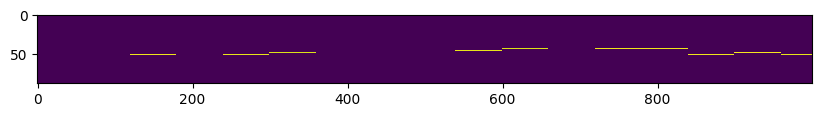

In [ ]:
import matplotlib.pyplot as plt

piano_roll = midi_file.get_piano_roll()[21 : 21 + 88]
plt.figure(figsize=(10, 10))
plt.imshow(piano_roll[:, 0:1000], interpolation="nearest")

## The dataset

In [ ]:
import os
from pathlib import Path
from typing import List

midi_folder = Path("../data/pianoteq/")

In [ ]:
midi_file_paths: List[Path] = []

for root, dir, files in os.walk(midi_folder):
    for file in files:
        if file.endswith(".mid"):
            midi_path = Path(root).joinpath("/".join(dir), file)
            midi_file_paths.append(midi_path)

print(f"Found {len(midi_file_paths)} midi files")

Found 772 midi files


In [ ]:
piano_rolls = []

for midi_file_path in midi_file_paths:
    m = pretty_midi.PrettyMIDI(midi_file=str(midi_file_path.absolute()))
    piano_rolls.append(m.get_piano_roll())

In [ ]:
piano_roll = piano_rolls[0]
piano_roll[:, ::1000]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


class PianoRollDataset(Dataset):
    def __init__(self, piano_rolls: List[np.ndarray], sample_length: int = 1000):
        # @todo allow padding and more arbitrary cuts
        # @todo skip empty samples
        # @todo allow for reduction in piano key range
        super().__init__()
        self.piano_rolls = piano_rolls
        self.sample_length = sample_length
        self._prepare_dataset()

    def _prepare_dataset(self):
        self.data: List[np.ndarray] = []
        for piano_roll in self.piano_rolls:
            for offset in range(0, piano_roll.shape[1], self.sample_length):
                sample = piano_roll[:, offset : offset + self.sample_length].astype(
                    np.float32
                )
                if sample.shape[-1] == self.sample_length:
                    self.data.append(sample)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
piano_rolls_dataset = PianoRollDataset(
    piano_rolls=piano_rolls,
)
len(piano_rolls_dataset)

17062

In [ ]:
piano_rolls[0].shape

(128, 90620)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # hardcoded - needs to be dynamic according to the input data
            nn.Linear(128 * 1000, 32),
            nn.ReLU(),
            nn.Linear(32, 128 * 1000),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(self.flatten(x))
        return torch.reshape(logits, shape=(-1, 128, 1000))
        return logits


model = SimpleNN()
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128000, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128000, bias=True)
  )
)


In [ ]:
batch_size = 64

# Create data loaders.
dataloader = DataLoader(piano_rolls_dataset, batch_size=batch_size)

for X in dataloader:
    print(f"Shape of X: {X.shape}")
    break

Shape of X: torch.Size([64, 128, 1000])


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, X in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4577.022461  [   64/17062]
loss: 1506.752075  [ 6464/17062]
loss: 1539.838501  [12864/17062]
Epoch 2
-------------------------------
loss: 2218.559082  [   64/17062]
loss: 1506.428467  [ 6464/17062]
loss: 1539.534546  [12864/17062]
Epoch 3
-------------------------------
loss: 2218.207275  [   64/17062]
loss: 1506.105103  [ 6464/17062]
loss: 1539.230591  [12864/17062]
Epoch 4
-------------------------------
loss: 2217.855957  [   64/17062]
loss: 1505.782227  [ 6464/17062]
loss: 1538.927002  [12864/17062]
Epoch 5
-------------------------------
loss: 2217.504883  [   64/17062]
loss: 1505.459717  [ 6464/17062]
loss: 1538.624023  [12864/17062]
Done!
